In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
movie_reviews = pd.read_csv("drive/My Drive/Colab Notebooks/data/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

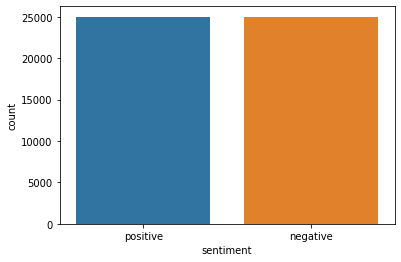

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

#Data Preprocessing

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [ ]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Embedding


In [ ]:
# Preparing the Embedding Layer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('drive/My Drive/Colab Notebooks/data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#Train Text Classification Model with a Convolutional Neural Network




In [ ]:
#Text Classification with a Convolutional Neural Network
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4955 - acc: 0.7569 - val_loss: 0.3914 - val_acc: 0.8230
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3609 - acc: 0.8426 - val_loss: 0.3657 - val_acc: 0.8372
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3122 - acc: 0.8702 - val_loss: 0.3844 - val_acc: 0.8280
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2729 - acc: 0.8915 - val_loss: 0.3457 - val_acc: 0.8446
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2412 - acc: 0.9065 - val_loss: 0.3405 - val_acc: 0.8490
Epoch 6/6
313/313 [==============================] - 1s 2ms/step - loss: 0.3436 - acc: 0.8468


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3436146378517151
Test Accuracy: 0.8468000292778015


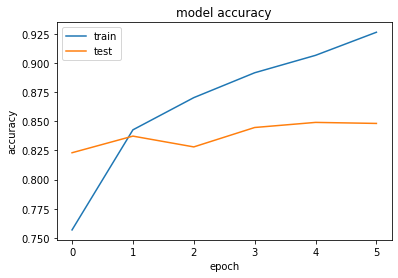

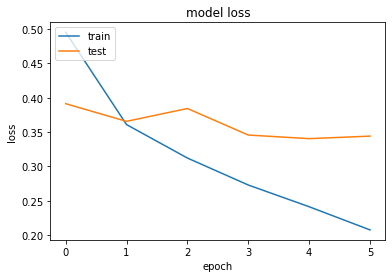

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#Train Text Classification Model with a Recurrent Neural Network (LSTM)

In [ ]:
# Text Classification with Recurrent Neural Network (LSTM)

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 3s 12ms/step - loss: 0.5534 - acc: 0.7108 - val_loss: 0.4735 - val_acc: 0.7861
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4441 - acc: 0.7937 - val_loss: 0.3996 - val_acc: 0.8154
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3960 - acc: 0.8206 - val_loss: 0.3793 - val_acc: 0.8284
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3690 - acc: 0.8359 - val_loss: 0.3720 - val_acc: 0.8325
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3461 - acc: 0.8494 - val_loss: 0.3546 - val_acc: 0.8441
Epoch 6/6
313/313 [==============================] - 1s 4ms/step - loss: 0.3337 - acc: 0.8525


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3336813747882843
Test Accuracy: 0.8525000214576721


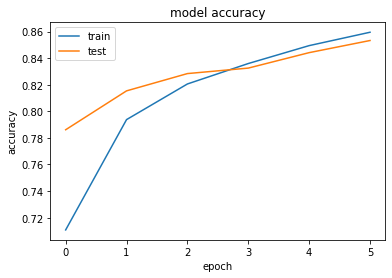

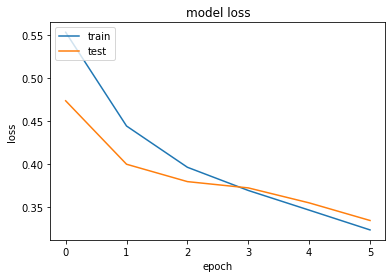

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Make Predictions


In [ ]:
# Making Predictions on Single Instance

instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.39544317]], dtype=float32)

In [ ]:
instance2 = 'This movie is really bad!! I hate it!'
print(instance2)

This movie is really bad!! I hate it!


In [ ]:
instance2 = tokenizer.texts_to_sequences(instance2)

flat_list = []
for sublist in instance2:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance2 = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance2)

array([[0.80362284]], dtype=float32)

#Load News Data

In [ ]:
# Deal with News data

news = pd.read_excel('drive/My Drive/Colab Notebooks/data/Combined_News_DJIA.xls')

news.isnull().values.any()

news.shape

(1989, 27)

In [ ]:
news.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into So...,'Russian tanks are moving towards the capital...,"""Afghan children raped with 'impunity,' U.N. ...",'150 Russian tanks have entered South Ossetia...,"""Breaking: Georgia invades South Ossetia, Rus...","""The 'enemy combatent' trials are nothing but...",'Georgian troops retreat from S. Osettain cap...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack ...,'Announcing:Class Action Lawsuit on Behalf of...,"""So---Russia and Georgia are at war and the N...","""China tells Bush to stay out of other countr...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia ge...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to p...",'This is a busy day: The European Union has ...,"""Georgia will withdraw 1,000 soldiers from Ir...",'Why the Pentagon Thinks Attacking Iran is a ...,'Caucasus in crisis: Georgia invades South Os...,'Indian shoe manufactory - And again in a se...,'Visitors Suffering from Mental Illnesses Ban...,"""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,'Why wont America and Nato help us? If they w...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli ...",'Georgian army flees in disarray as Russians ...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zea...,'Russia angered by Israeli military sale to G...,'An American citizen living in S.Ossetia blam...,'Welcome To World War IV! Now In High Definit...,"""Georgia's move, a mistake of monumental prop...",'Russia presses deeper into Georgia; U.S. say...,'Abhinav Bindra wins first ever Individual Ol...,' U.S. ship heads for Arctic to define territ...,'Drivers in a Jerusalem taxi station threaten...,'The French Team is Stunned by Phelps and the...,'Israel and the US behind the Georgian aggres...,"'""Do not believe TV, neither Russian nor Geor...",'Riots are still going on in Montreal (Canada...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Tort...,' Russia has just beaten the United States ov...,'Perhaps *the* question about the Georgia - R...,'Russia is so much better at war',"""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would hav...","""Al-Qa'eda is losing support in Iraq because ...",'Ceasefire in Georgia: Putin Outmaneuvers the...,'Why Microsoft and Intel tried to kill the XO...,'Stratfor: The Russo-Georgian War and the Bal...,"""I'm Trying to Get a Sense of This Whole Geor...","""The US military was surprised by the timing ...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the S...",'CNN use footage of Tskhinvali ruins to cover...,'Beginning a war as the Olympics were opening...,'55 pyramids as large as the Luxor stacked in...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know t...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious ...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led y...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgi...,'Christopher King argues that the US and NATO...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man..."


In [ ]:
news['text'] = news['Top1'] +  news['Top2'] + news['Top3'] + news['Top4'] + news['Top5'] + news['Top6'] + news['Top7'] + news['Top8'] + news['Top9'] + news['Top10'] + news['Top11'] + news['Top12'] + news['Top13'] + news['Top14'] + news['Top15'] + news['Top16'] + news['Top17'] + news['Top18'] + news['Top19'] + news['Top20'] + news['Top21'] + news['Top22'] + news['Top23'] + news['Top24'] + news['Top25']

In [ ]:
news['text'] = news['text'].apply(str)

#Sentiment Analysis

In [ ]:
#Function to preprocess each review
    # 'r' is used to differentiate regex escaping and normal escape sequence 
def preprocess(sen):
    # Function to remove html tags is called
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    # '^' means NOT
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

# Function to remove html tags
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

In [ ]:
NS = []
text = list(news['text'])
for sen in text:
    NS.append(preprocess(sen))

In [ ]:
NS[1]

' Why wont America and Nato help us If they wont help us now why did we help them in Iraq Bush puts foot down on Georgian conflict Jewish Georgian minister Thanks to Israeli training we re fending off Russia Georgian army flees in disarray as Russians advance Gori abandoned to Russia without shot fired Olympic opening ceremony fireworks faked What were the Mossad with fraudulent New Zealand Passports doing in Iraq Russia angered by Israeli military sale to Georgia An American citizen living in Ossetia blames S and Georgian leaders for the genocide of innocent people Welcome To World War IV Now In High Definition Georgia move mistake of monumental proportions Russia presses deeper into Georgia S says regime change is goal Abhinav Bindra wins first ever Individual Olympic Gold Medal for India S ship heads for Arctic to define territory Drivers in Jerusalem taxi station threaten to quit rather than work for their new boss an Arab The French Team is Stunned by Phelps and the m Relay Team I

In [ ]:
News = tokenizer.texts_to_sequences(NS)

News = pad_sequences(News, padding='post', maxlen=300)


In [ ]:
news['sentiment_score'] = model.predict(News, batch_size=1, verbose =0)

In [ ]:
news.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,text,sentiment_score
0,2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into So...,'Russian tanks are moving towards the capital...,"""Afghan children raped with 'impunity,' U.N. ...",'150 Russian tanks have entered South Ossetia...,"""Breaking: Georgia invades South Ossetia, Rus...","""The 'enemy combatent' trials are nothing but...",'Georgian troops retreat from S. Osettain cap...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack ...,'Announcing:Class Action Lawsuit on Behalf of...,"""So---Russia and Georgia are at war and the N...","""China tells Bush to stay out of other countr...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia ge...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to p...",'This is a busy day: The European Union has ...,"""Georgia will withdraw 1,000 soldiers from Ir...",'Why the Pentagon Thinks Attacking Iran is a ...,'Caucasus in crisis: Georgia invades South Os...,'Indian shoe manufactory - And again in a se...,'Visitors Suffering from Mental Illnesses Ban...,"""No Help for Mexico's Kidnapping Surge""","""Georgia 'downs two Russian warplanes' as cou...",0.708408
1,2008-08-11,1,'Why wont America and Nato help us? If they w...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli ...",'Georgian army flees in disarray as Russians ...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zea...,'Russia angered by Israeli military sale to G...,'An American citizen living in S.Ossetia blam...,'Welcome To World War IV! Now In High Definit...,"""Georgia's move, a mistake of monumental prop...",'Russia presses deeper into Georgia; U.S. say...,'Abhinav Bindra wins first ever Individual Ol...,' U.S. ship heads for Arctic to define territ...,'Drivers in a Jerusalem taxi station threaten...,'The French Team is Stunned by Phelps and the...,'Israel and the US behind the Georgian aggres...,"'""Do not believe TV, neither Russian nor Geor...",'Riots are still going on in Montreal (Canada...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Tort...,' Russia has just beaten the United States ov...,'Perhaps *the* question about the Georgia - R...,'Russia is so much better at war',"""So this is what it's come to: trading sex fo...",'Why wont America and Nato help us? If they w...,0.982830
2,2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would hav...","""Al-Qa'eda is losing support in Iraq because ...",'Ceasefire in Georgia: Putin Outmaneuvers the...,'Why Microsoft and Intel tried to kill the XO...,'Stratfor: The Russo-Georgian War and the Bal...,"""I'm Trying to Get a Sense of This Whole Geor...","""The US military was surprised by the timing ...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the S...",'CNN use footage of Tskhinvali ruins to cover...,'Beginning a war as the Olympics were opening...,'55 pyramids as large as the Luxor stacked in...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know t...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious ...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led y...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgi...,'Christopher King argues that the US and NATO...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man...",'Remember that adorable 9-year-old who sang a...,0.935311
3,2008-08-13,0,' U.S. re

In [ ]:
from google.colab import files
news.to_excel('newsLSTM.xlsx')
files.download('newsLSTM.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preparing for Machine Learning Models

In [ ]:
news_sub = news[['Label','sentiment_score', 'text']]
news_sub.head()

,Label,sentiment_score,text
0,0,0.708408,"""Georgia 'downs two Russian warplanes' as cou..."
1,1,0.982830,'Why wont America and Nato help us? If they w...
2,0,0.935311,'Remember that adorable 9-year-old who sang a...
3,0,0.721639,' U.S. refuses Israel weapons to attack Iran:...
4,1,0.971837,'All the experts admit that we should legalis...


In [ ]:
news_sub.corr(method ='pearson')

,Label,sentiment_score
Label,1.000000,0.023797
sentiment_score,0.023797,1.000000


In [ ]:
news_sub.groupby('Label').mean()

,sentiment_score
Label,
0,0.494450
1,0.506372


In [ ]:
news_sub.dtypes

Label                int64
sentiment_score    float32
text                object
dtype: object

In [ ]:
x = news_sub.drop(['Label'], axis=1)
y = news_sub['Label']

In [ ]:
X_train

,sentiment_score,text
1859,0.604849,"Germany recruits 8,500 teachers to teach Germa..."
685,0.316509,World-famous and beloved Chinese artist Ai Wei...
1972,0.687303,"Vandals Destroy 8,000-Yr-Old Aboriginal Artwor..."
1887,0.382144,"North Korea satellite 'tumbling in orbit,' U.S..."
895,0.568304,"Guatemala, Colombia, and Mexico are considerin..."
...,...,...
1393,0.545174,Ukrainian Skier Pulls Out of Olympics To Join ...
1344,0.549736,Bill Clinton says security does not justify es...
527,0.548931,Should the Pope face charges?\nA renowned lawy...
1149,0.259383,"A huge comet is headed for Mars. If it hits, ""..."


In [ ]:
y_train

# ML With Sentiment Scores(NLTK toolkit)

In [ ]:
df = pd.read_excel("drive/My Drive/Colab Notebooks/data/Data_ML.xlsx")

print(df.isnull().values.any())

print(df.shape)

False
(1989, 155)


In [ ]:
df.head(3)

,Date,Label,polarity,subjectivity,Topic,TextCluster_SVD1,TextCluster_SVD2,TextCluster_SVD3,TextCluster_SVD4,TextCluster_SVD5,TextCluster_SVD6,TextCluster_SVD7,TextCluster_SVD8,TextCluster_SVD9,TextCluster_SVD10,TextCluster_SVD11,TextCluster_SVD12,TextCluster_SVD13,TextCluster_SVD14,TextCluster_SVD15,TextCluster_SVD16,TextCluster_SVD17,TextCluster_SVD18,TextCluster_SVD19,TextCluster_SVD20,TextCluster_SVD21,TextCluster_SVD22,TextCluster_SVD23,TextCluster_SVD24,TextCluster_SVD25,TextCluster_SVD26,TextCluster_SVD27,TextCluster_SVD28,TextCluster_SVD29,TextCluster_SVD30,TextCluster_SVD31,TextCluster_SVD32,TextCluster_SVD33,TextCluster_SVD34,TextCluster_SVD35,...,TextCluster_SVD111,TextCluster_SVD112,TextCluster_SVD113,TextCluster_SVD114,TextCluster_SVD115,TextCluster_SVD116,TextCluster_SVD117,TextCluster_SVD118,TextCluster_SVD119,TextCluster_SVD120,TextCluster_SVD121,TextCluster_SVD122,TextCluster_SVD123,TextCluster_SVD124,TextCluster_SVD125,TextCluster_SVD126,TextCluster_SVD127,TextCluster_SVD128,TextCluster_SVD129,TextCluster_SVD130,TextCluster_SVD131,TextCluster_SVD132,TextCluster_SVD133,TextCluster_SVD134,TextCluster_SVD135,TextCluster_SVD136,TextCluster_SVD137,TextCluster_SVD138,TextCluster_SVD139,TextCluster_SVD140,TextCluster_SVD141,TextCluster_SVD142,TextCluster_SVD143,TextCluster_SVD144,TextCluster_SVD145,TextCluster_SVD146,TextCluster_SVD147,TextCluster_SVD148,TextCluster_SVD149,TextCluster_SVD150
0,2008-08-08,0,-0.065978,0.303496,18,0.070340,-0.053418,0.007628,-0.039590,0.013758,-0.006961,0.003005,-0.009582,0.004257,-0.035629,0.053125,-0.042869,0.056493,-0.045300,0.064174,-0.043070,0.009018,-0.088200,0.029373,-0.060276,0.026729,-0.054988,0.064938,-0.041884,0.037314,-0.049207,0.036609,-0.052739,0.007796,-0.004014,0.046403,-0.029370,0.006170,-0.001426,0.042902,...,0.101724,-0.079988,0.021861,-0.226352,0.082787,-0.038550,0.065302,-0.110700,0.072415,-0.135987,0.092684,-0.043056,0.126786,-0.071721,0.243436,-0.006753,0.000322,-0.080022,0.010144,-0.066310,0.363848,-0.097505,0.206657,-0.095168,0.004715,-0.104697,0.100755,-0.074710,0.015919,-0.050645,0.116522,-0.017147,0.039564,-0.061400,0.047492,-0.122964,0.051517,-0.151404,0.119570,-0.008954
1,2008-08-11,1,0.026123,0.331319,12,0.051980,-0.058078,-0.015400,-0.007448,0.046362,0.002541,-0.087866,0.085167,-0.003734,-0.008321,-0.028623,0.040409,-0.004584,-0.000692,-0.002099,-0.024974,0.045334,0.036934,0.021652,0.068953,0.013503,0.053537,-0.094969,-0.001640,0.003632,-0.040337,-0.006653,-0.018416,0.031414,-0.000114,0.004470,-0.005188,0.112886,-0.025753,-0.056319,...,-0.093461,-0.068544,0.034504,-0.028307,-0.095676,0.104153,-0.095475,-0.020406,-0.054456,0.076732,-0.087010,-0.090862,-0.043874,-0.017090,0.012035,0.090027,0.024193,-0.079964,0.101046,-0.015903,-0.136454,-0.087935,-0.034662,0.011328,0.043837,-0.163852,0.052653,0.016805,-0.126830,0.051297,0.195758,-0.130426,0.034301,-0.017566,-0.027512,-0.005659,0.008784,-0.060372,0.034575,0.116155
2,2008-08-12,0,-0.158049,0.587207,12,0.189981,-0.047806,0.068441,-0.014393,-0.006442,-0.066779,-0.037231,-0.009753,0.035989,-0.205988,0.049160,0.169126,0.065916,-0.004228,-0.018234,-0.081065,-0.006108,-0.037406,-0.086733,-0.015370,-0.040718,-0.031523,-0.048353,0.040183,0.096255,-0.021080,0.008966,-0.014644,-0.067264,-0.025443,0.009030,-0.051706,0.070022,0.048911,-0.006165,...,0.104727,-0.061049,-0.013598,-0.042812,-0.122341,-0.083730,-0.091760,-0.042137,0.051752,-0.001305,0.055347,-0.020711,0.100515,-0.045093,-0.132599,0.084397,0.060316,-0.027973,-0.049351,0.163951,0.083682,-0.118854,-0.036862,-0.109198,0.034062,-0.047079,-0.051648,0.139000,-0.036143,-0.037677,-0.017577,0.127634,-0.116772,-0.006697,-0.100506,0.192060,-0.014918,-0.090984,-0.045369,0.048514


In [ ]:
x = df.drop(['Label','Date'], axis=1)
y = df['Label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=10)

In [ ]:
X_train

,Date,polarity,subjectivity,Topic,TextCluster_SVD1,TextCluster_SVD2,TextCluster_SVD3,TextCluster_SVD4,TextCluster_SVD5,TextCluster_SVD6,TextCluster_SVD7,TextCluster_SVD8,TextCluster_SVD9,TextCluster_SVD10,TextCluster_SVD11,TextCluster_SVD12,TextCluster_SVD13,TextCluster_SVD14,TextCluster_SVD15,TextCluster_SVD16,TextCluster_SVD17,TextCluster_SVD18,TextCluster_SVD19,TextCluster_SVD20,TextCluster_SVD21,TextCluster_SVD22,TextCluster_SVD23,TextCluster_SVD24,TextCluster_SVD25,TextCluster_SVD26,TextCluster_SVD27,TextCluster_SVD28,TextCluster_SVD29,TextCluster_SVD30,TextCluster_SVD31,TextCluster_SVD32,TextCluster_SVD33,TextCluster_SVD34,TextCluster_SVD35,TextCluster_SVD36,...,TextCluster_SVD111,TextCluster_SVD112,TextCluster_SVD113,TextCluster_SVD114,TextCluster_SVD115,TextCluster_SVD116,TextCluster_SVD117,TextCluster_SVD118,TextCluster_SVD119,TextCluster_SVD120,TextCluster_SVD121,TextCluster_SVD122,TextCluster_SVD123,TextCluster_SVD124,TextCluster_SVD125,TextCluster_SVD126,TextCluster_SVD127,TextCluster_SVD128,TextCluster_SVD129,TextCluster_SVD130,TextCluster_SVD131,TextCluster_SVD132,TextCluster_SVD133,TextCluster_SVD134,TextCluster_SVD135,TextCluster_SVD136,TextCluster_SVD137,TextCluster_SVD138,TextCluster_SVD139,TextCluster_SVD140,TextCluster_SVD141,TextCluster_SVD142,TextCluster_SVD143,TextCluster_SVD144,TextCluster_SVD145,TextCluster_SVD146,TextCluster_SVD147,TextCluster_SVD148,TextCluster_SVD149,TextCluster_SVD150
1859,2015-12-28,0.026222,0.254073,10,0.035961,-0.034888,0.062151,0.001897,-0.049914,-0.006819,-0.004078,0.025674,0.023934,-0.018948,0.026819,-0.004080,0.015223,-0.006680,0.010078,-0.007221,0.033822,0.017229,-0.009689,-0.002299,0.020678,0.002586,0.045444,0.011049,-0.003344,0.010819,0.000555,-0.001779,0.003321,0.020409,-0.002025,-0.014598,-0.022851,0.008132,0.015710,0.028098,...,0.059296,-0.143169,0.024786,0.121353,0.132127,-0.080990,-0.050703,0.034702,0.104499,0.033094,-0.145787,0.056456,0.022812,-0.109996,0.050724,-0.012410,0.011442,-0.132214,-0.164716,-0.029711,-0.218139,-0.022867,-0.090488,-0.036112,0.043410,0.136300,0.118520,-0.085787,-0.089442,-0.081664,0.041939,-0.012297,-0.059561,-0.039815,0.047522,0.111483,-0.227116,-0.204344,0.116033,-0.081394
685,2011-04-28,0.084091,0.371970,4,0.074825,-0.038242,-0.017757,0.004020,0.003515,-0.023631,-0.009788,-0.031818,-0.026938,-0.040749,0.014180,0.049431,0.068147,-0.011805,0.012017,-0.052530,0.007584,0.052426,0.013858,0.003015,0.027149,-0.007833,0.023966,-0.023383,0.020872,0.096076,-0.056252,-0.046995,0.016316,-0.011578,0.028033,0.023662,0.010828,-0.086230,0.053674,-0.047009,...,0.214875,-0.062422,-0.125435,-0.077787,-0.026713,-0.063205,0.248555,-0.033746,0.003894,-0.045959,0.094169,0.057377,0.267908,-0.178311,-0.149328,-0.074448,0.064437,-0.052161,-0.116670,-0.059885,0.206831,-0.048226,0.087001,-0.092773,-0.089645,-0.038331,0.128814,0.107789,-0.047311,0.179383,-0.122416,-0.003267,0.046747,-0.121370,0.005178,0.037926,0.099323,0.076500,0.160029,0.059312
1972,2016-06-09,0.111211,0.317637,10,0.065017,-0.068005,0.011517,-0.016354,0.012548,-0.043051,-0.066953,-0.047389,0.026101,0.008670,0.112868,0.056228,-0.048244,-0.026818,-0.036106,0.028797,-0.136849,0.063366,0.085751,-0.051605,0.104434,0.033101,-0.179119,-0.088142,-0.125838,-0.176433,0.115925,0.022033,0.082976,0.040232,0.111698,-0.040476,0.007141,-0.040310,-0.005297,0.065751,...,0.052273,0.022762,-0.046136,0.089112,-0.037823,0.199912,-0.047336,-0.061805,-0.007195,0.026708,0.058472,0.020166,0.159917,-0.047024,0.011355,0.008848,-0.045376,0.025083,-0.010049,-0.041700,0.045594,-0.035555,0.116990,-0.062527,0.015451,-0.096374,0.071836,-0.132930,0.075286,-0.022505,0.050186,0.041465,-0.034845,0.159491,-0.035300,-0.031133,-0.048474,0.056347,0.170175,0.087010
1887,2016-02-08,0.045416,0.377368,10,0.149867,-0.106181,-0.009912,-0.004904,-0.027242,-0.058995,-0.023931,-0.035553,-0.004210,-0.084459,0.164955,-0.003027,0.001815,0.028739,-0.088702,0.023499,0.011871,0.054980,-0.018930,0.065535,0.031819,0.061849,-0.027448,-0.047284,-0.053469,-0.0

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier(n_neighbors=7)
Knn.fit(X_train, y_train)
pred_Knn = Knn.predict(X_test)
print(classification_report(y_test, pred_Knn))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=Knn,X=x, y=y, cv=10)
print(cross_val.mean())
print(Knn.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.51      0.42      0.46       185
           1       0.56      0.66      0.61       213

    accuracy                           0.55       398
   macro avg       0.54      0.54      0.53       398
weighted avg       0.54      0.55      0.54       398

0.5460154306887975
0.5452261306532663


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1, random_state = 30)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=rf,X=x, y=y, cv=10)
print(cross_val.mean())
print(rf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       185
           1       0.60      0.58      0.59       213

    accuracy                           0.57       398
   macro avg       0.57      0.57      0.57       398
weighted avg       0.57      0.57      0.57       398

0.5314324145982438
0.5728643216080402


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state= 2)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print(classification_report(y_test, pred_dt))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=dt,X=x, y=y, cv=10)
print(cross_val.mean())
print(dt.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.60      0.35      0.44       185
           1       0.58      0.80      0.67       213

    accuracy                           0.59       398
   macro avg       0.59      0.57      0.56       398
weighted avg       0.59      0.59      0.56       398

0.5726536724024162
0.5879396984924623


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train) 
pred_lr = lr.predict(X_test)
print(classification_report(y_test, pred_lr))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=lr,X=x, y=y, cv=10)
print(cross_val.mean())
print(lr.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       185
           1       0.64      0.72      0.68       213

    accuracy                           0.64       398
   macro avg       0.63      0.63      0.63       398
weighted avg       0.63      0.64      0.63       398



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6159078219379727
0.635678391959799


In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01, C=1, kernel='rbf')
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=svm,X=x, y=y, cv=10)
print(cross_val.mean())
print(svm.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.54      1.00      0.70       213

    accuracy                           0.54       398
   macro avg       0.27      0.50      0.35       398
weighted avg       0.29      0.54      0.37       398

0.5309222882087203
0.535175879396985


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)
print(classification_report(y_test, pred_gbc))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print(gbc.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       185
           1       0.61      0.65      0.63       213

    accuracy                           0.59       398
   macro avg       0.59      0.59      0.59       398
weighted avg       0.59      0.59      0.59       398

0.5877392010557839
0.592964824120603


In [ ]:
import xgboost as xgb
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test) 
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 
print(classification_report(y_test, preds))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print("accuracy: %f" % (accuracy))

              precision    recall  f1-score   support

           0       0.58      0.33      0.42       185
           1       0.58      0.79      0.67       213

    accuracy                           0.58       398
   macro avg       0.58      0.56      0.54       398
weighted avg       0.58      0.58      0.55       398

0.5877392010557839
accuracy: 0.577889


In [ ]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', Knn),('Decision Tree', dt), ('Random Forest', rf), ('SVM', svm)]

for clf_name, clf in classifiers: 
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
pred_vc = vc.predict(X_test)
print(classification_report(y_test, pred_vc))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print(vc.score(X_test, y_test))

Logistic Regression : 0.636
K Nearest Neighbours : 0.545
Decision Tree : 0.588
Random Forest : 0.573
SVM : 0.535
              precision    recall  f1-score   support

           0       0.69      0.34      0.46       185
           1       0.60      0.87      0.71       213

    accuracy                           0.62       398
   macro avg       0.65      0.60      0.58       398
weighted avg       0.64      0.62      0.59       398

0.5877392010557839
0.6231155778894473


In [ ]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,15,20,25,30,35,40,45,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df1 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df1

,model,best_score,best_params
0,svm,0.603335,"{'C': 10, 'kernel': 'linear'}"
1,random_forest,0.602318,{'n_estimators': 45}
2,logistic_regression,0.607349,{'C': 10}


#ML With Sentiment Scores(LTSM)

In [ ]:
df['sentiment_score'] = news['sentiment_score']

In [ ]:
x1 = df.drop(['Label','Date', 'polarity',	'subjectivity'], axis=1)
y1 = df['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x1,y1,test_size=0.2, random_state=10)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier(n_neighbors=8)
Knn.fit(X_train, y_train)
pred_Knn = Knn.predict(X_test)
print(classification_report(y_test, pred_Knn))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=Knn,X=x, y=y, cv=10)
print(cross_val.mean())
print(Knn.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54       185
           1       0.59      0.54      0.57       213

    accuracy                           0.56       398
   macro avg       0.56      0.56      0.55       398
weighted avg       0.56      0.56      0.56       398

0.5369600527891986
0.5552763819095478


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=35, random_state = 30)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=rf,X=x, y=y, cv=10)
print(cross_val.mean())
print(rf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.59      0.51      0.55       185
           1       0.62      0.69      0.65       213

    accuracy                           0.61       398
   macro avg       0.61      0.60      0.60       398
weighted avg       0.61      0.61      0.60       398

0.5736764631236992
0.6080402010050251


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state= 2)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)
print(classification_report(y_test, pred_dt))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=dt,X=x, y=y, cv=10)
print(cross_val.mean())
print(dt.score(X_test, y_test))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train) 
pred_lr = lr.predict(X_test)
print(classification_report(y_test, pred_lr))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=lr,X=x, y=y, cv=10)
print(cross_val.mean())
print(lr.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       185
           1       0.64      0.72      0.68       213

    accuracy                           0.63       398
   macro avg       0.63      0.62      0.62       398
weighted avg       0.63      0.63      0.63       398

0.6159078219379727
0.6306532663316583


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01, C=1, kernel='rbf')
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=svm,X=x, y=y, cv=10)
print(cross_val.mean())
print(svm.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.54      1.00      0.70       213

    accuracy                           0.54       398
   macro avg       0.27      0.50      0.35       398
weighted avg       0.29      0.54      0.37       398

0.5309222882087203
0.535175879396985


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)
print(classification_report(y_test, pred_gbc))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print(gbc.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       185
           1       0.63      0.66      0.64       213

    accuracy                           0.61       398
   macro avg       0.61      0.60      0.60       398
weighted avg       0.61      0.61      0.61       398

0.5877392010557839
0.6080402010050251


In [ ]:
import xgboost as xgb
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test) 
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 
print(classification_report(y_test, preds))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print("accuracy: %f" % (accuracy))

              precision    recall  f1-score   support

           0       0.57      0.34      0.42       185
           1       0.58      0.78      0.66       213

    accuracy                           0.58       398
   macro avg       0.57      0.56      0.54       398
weighted avg       0.58      0.58      0.55       398

0.5877392010557839
accuracy: 0.575377


In [ ]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', Knn),('Decision Tree', dt), ('Random Forest', rf), ('SVM', svm)]

for clf_name, clf in classifiers: 
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
pred_vc = vc.predict(X_test)
print(classification_report(y_test, pred_vc))
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val = cross_val_score(estimator=gbc,X=x, y=y, cv=10)
print(cross_val.mean())
print(vc.score(X_test, y_test))

Logistic Regression : 0.631
K Nearest Neighbours : 0.590
Decision Tree : 0.568
Random Forest : 0.595
SVM : 0.535
              precision    recall  f1-score   support

           0       0.68      0.38      0.49       185
           1       0.61      0.85      0.71       213

    accuracy                           0.63       398
   macro avg       0.64      0.61      0.60       398
weighted avg       0.64      0.63      0.61       398

0.5877392010557839
0.628140703517588


In [ ]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,15,20,25,30,35,40,45,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2

,model,best_score,best_params
0,svm,0.603335,"{'C': 10, 'kernel': 'linear'}"
1,random_forest,0.602302,{'n_estimators': 45}
2,logistic_regression,0.607349,{'C': 10}
